# 🔮 Flu Forecast Hub - Forecasting Models

This notebook demonstrates time-series forecasting for flu ILI data.

**Models:**
- ARIMA (AutoRegressive Integrated Moving Average)
- Moving Average (baseline)

**Author:** Anita  
**Date:** 2025

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Get the notebook's directory and find project root
notebook_dir = os.getcwd()

# Check if we're in notebooks folder or project root
if 'notebooks' in notebook_dir:
    PROJECT_ROOT = os.path.dirname(notebook_dir)
elif os.path.exists('backend/app'):
    PROJECT_ROOT = notebook_dir
else:
    PROJECT_ROOT = os.path.dirname(notebook_dir)

# Add backend/app to path
app_path = os.path.join(PROJECT_ROOT, 'backend', 'app')
sys.path.insert(0, app_path)

from forecaster import FluForecaster, run_forecast_pipeline
from data_fetcher import fetch_sample_data

plt.style.use('seaborn-v0_8-whitegrid')
print(f"   Project root: {PROJECT_ROOT}")
print(f"   App path: {app_path}")

   Project root: c:\Users\Ani\OneDrive\Desktop\flu-forecast-hub
   App path: c:\Users\Ani\OneDrive\Desktop\flu-forecast-hub\backend\app


## 2. Load Data

In [2]:
# Load data
df = fetch_sample_data()
print(f"Data shape: {df.shape}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")
df.head()

Data shape: (312, 7)
Years: 2020 - 2025


,year,week,region,ili_percentage,num_providers,total_patients,total_ili
0,2020,1,National,5.00,3294,104886,7265
1,2020,2,National,4.12,3482,94131,3919
2,2020,3,National,6.33,3332,50769,3391
3,2020,4,National,6.83,2385,55311,6051
4,2020,5,National,4.23,3337,78693,7396


## 3. Train/Test Split

In [3]:
# Initialize forecaster
forecaster = FluForecaster()

# Split data: hold out last 12 weeks for testing
TEST_WEEKS = 12
train, test = forecaster.prepare_data(df, test_size=TEST_WEEKS)

print(f"Training data: {len(train)} weeks")
print(f"Test data: {len(test)} weeks")

Training data: 300 weeks
Test data: 12 weeks


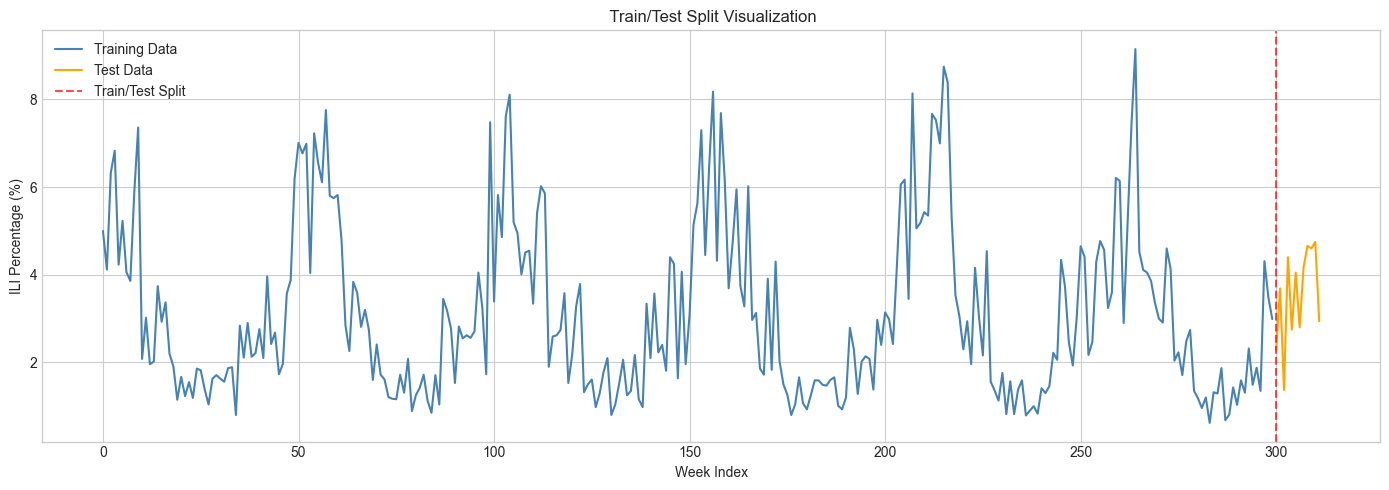

In [4]:
# Visualize train/test split
plt.figure(figsize=(14, 5))

plt.plot(range(len(train)), train, label='Training Data', color='steelblue')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test Data', color='orange')
plt.axvline(x=len(train), color='red', linestyle='--', alpha=0.7, label='Train/Test Split')

plt.xlabel('Week Index')
plt.ylabel('ILI Percentage (%)')
plt.title(' Train/Test Split Visualization')
plt.legend()
plt.tight_layout()
plt.show()

## 4. ARIMA Model

In [5]:
# Fit ARIMA model
print("Fitting ARIMA model...")
forecaster.fit_arima(train, order=(2, 1, 2))
print(f" Model fitted: {forecaster.model_type}")

Fitting ARIMA model...
 Model fitted: ARIMA


In [6]:
# Predict on test period
predictions = forecaster.predict(steps=len(test))

print("Predictions vs Actual:")
comparison = pd.DataFrame({
    'Actual': test.values,
    'Predicted': predictions,
    'Error': test.values - predictions
})
comparison

Predictions vs Actual:


,Actual,Predicted,Error
0,2.29,3.293331,-1.003331
1,3.69,3.056096,0.633904
2,1.37,3.242871,-1.872871
3,4.40,3.095736,1.304264
4,2.75,3.211650,-0.461650
5,4.05,3.120331,0.929669
6,2.80,3.192273,-0.392273
7,4.17,3.135596,1.034404
8,4.66,3.180247,1.479753
9,4.60,3.145071,1.454929


In [7]:
# Evaluate model
metrics = forecaster.evaluate(test, predictions)

print(" Model Performance:")

for metric, value in metrics.items():
    print(f"   {metric}: {value}")

 Model Performance:
   MAE: 1.0296
   RMSE: 1.1459
   MAPE: 34.14


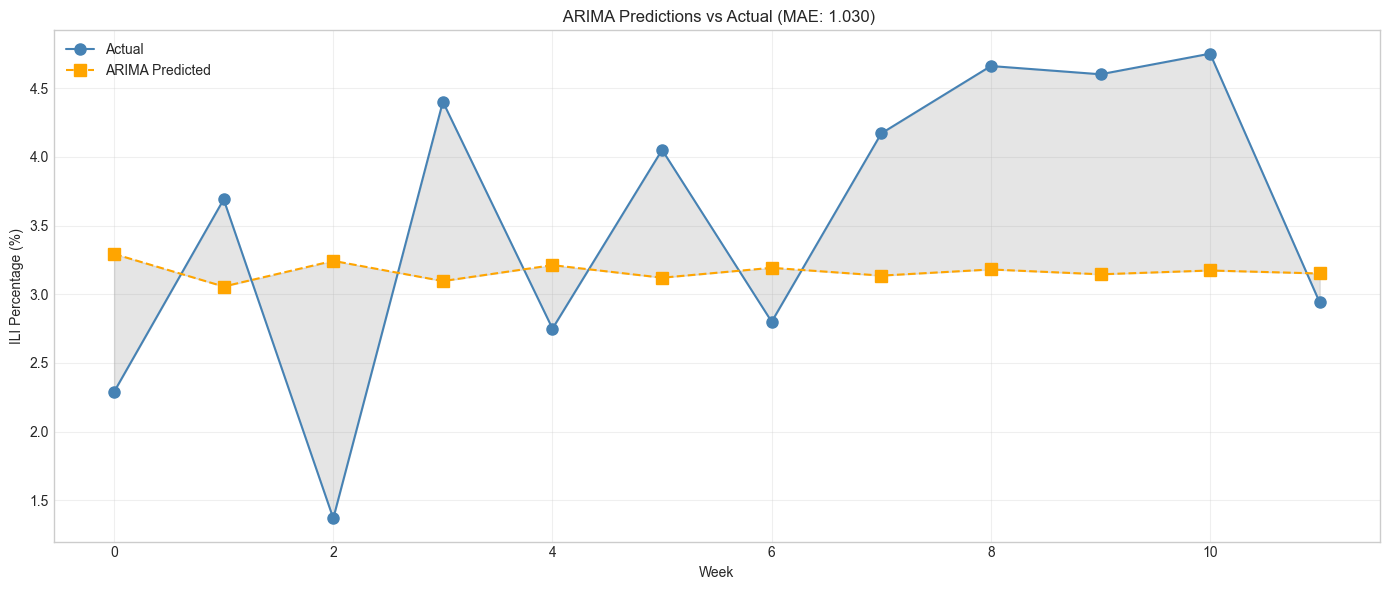

In [8]:
# Visualize predictions vs actual
plt.figure(figsize=(14, 6))

weeks = range(len(test))
plt.plot(weeks, test.values, 'o-', label='Actual', color='steelblue', markersize=8)
plt.plot(weeks, predictions, 's--', label='ARIMA Predicted', color='orange', markersize=8)

plt.fill_between(weeks, test.values, predictions, alpha=0.2, color='gray')

plt.xlabel('Week')
plt.ylabel('ILI Percentage (%)')
plt.title(f' ARIMA Predictions vs Actual (MAE: {metrics["MAE"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Compare Models

In [9]:
# Compare ARIMA vs Moving Average

# ARIMA (already done)
arima_forecaster = FluForecaster()
arima_forecaster.fit_arima(train)
arima_pred = arima_forecaster.predict(steps=len(test))
arima_metrics = arima_forecaster.evaluate(test, arima_pred)

# Moving Average
ma_forecaster = FluForecaster()
ma_forecaster.fit_moving_average(train, window=4)
ma_pred = ma_forecaster.predict(steps=len(test))
ma_metrics = ma_forecaster.evaluate(test, ma_pred)

# Comparison table
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'ARIMA': [arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE']],
    'Moving Avg': [ma_metrics['MAE'], ma_metrics['RMSE'], ma_metrics['MAPE']]
})

print(" Model Comparison:")
print(comparison_df.to_string(index=False))

 Model Comparison:
Metric   ARIMA  Moving Avg
   MAE  1.0296      0.9399
  RMSE  1.1459      1.0694
  MAPE 34.1400     31.6400


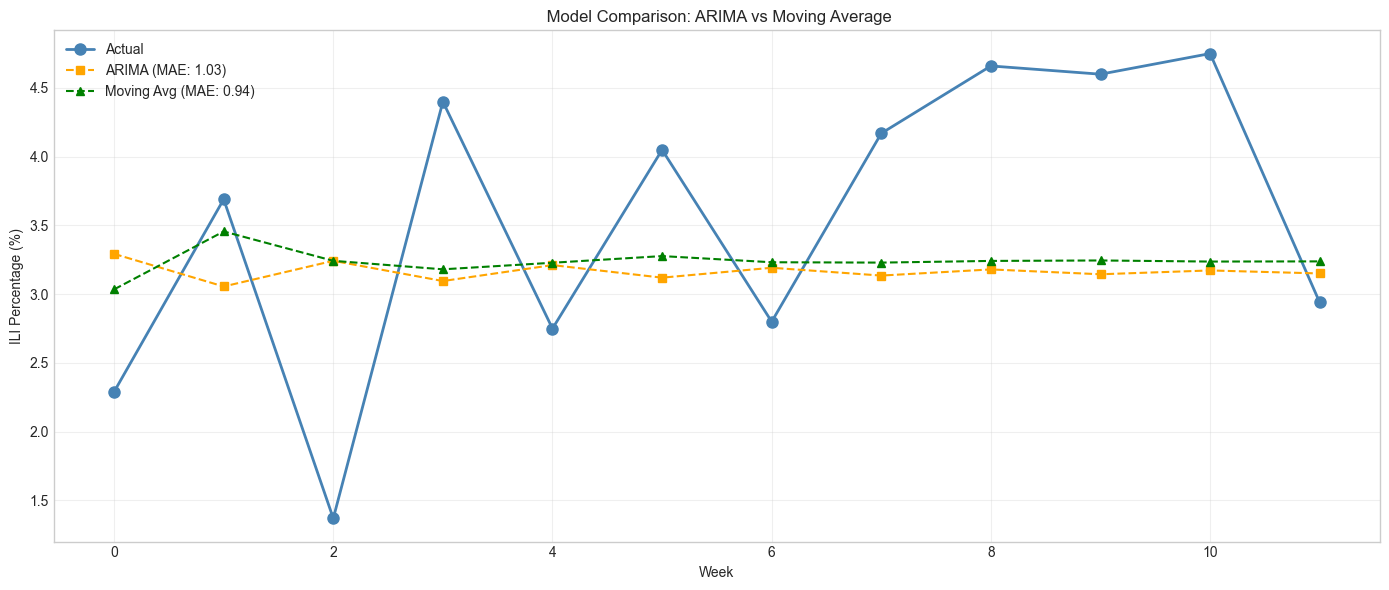

In [10]:
# Visual comparison
plt.figure(figsize=(14, 6))

weeks = range(len(test))
plt.plot(weeks, test.values, 'o-', label='Actual', color='steelblue', markersize=8, linewidth=2)
plt.plot(weeks, arima_pred, 's--', label=f'ARIMA (MAE: {arima_metrics["MAE"]:.2f})', color='orange', markersize=6)
plt.plot(weeks, ma_pred, '^--', label=f'Moving Avg (MAE: {ma_metrics["MAE"]:.2f})', color='green', markersize=6)

plt.xlabel('Week')
plt.ylabel('ILI Percentage (%)')
plt.title(' Model Comparison: ARIMA vs Moving Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Future Forecast

In [11]:
# Refit on ALL data and forecast future
FORECAST_WEEKS = 8

full_data = pd.Series(df['ili_percentage'].values)
final_forecaster = FluForecaster()
final_forecaster.fit_arima(full_data)

future_forecast = final_forecaster.predict(steps=FORECAST_WEEKS)

print(f" Next {FORECAST_WEEKS} Weeks Forecast:")
print("=" * 30)
for i, val in enumerate(future_forecast, 1):
    print(f"   Week +{i}: {val:.2f}%")

 Next 8 Weeks Forecast:
   Week +1: 3.76%
   Week +2: 3.82%
   Week +3: 3.77%
   Week +4: 3.78%
   Week +5: 3.78%
   Week +6: 3.78%
   Week +7: 3.78%
   Week +8: 3.78%


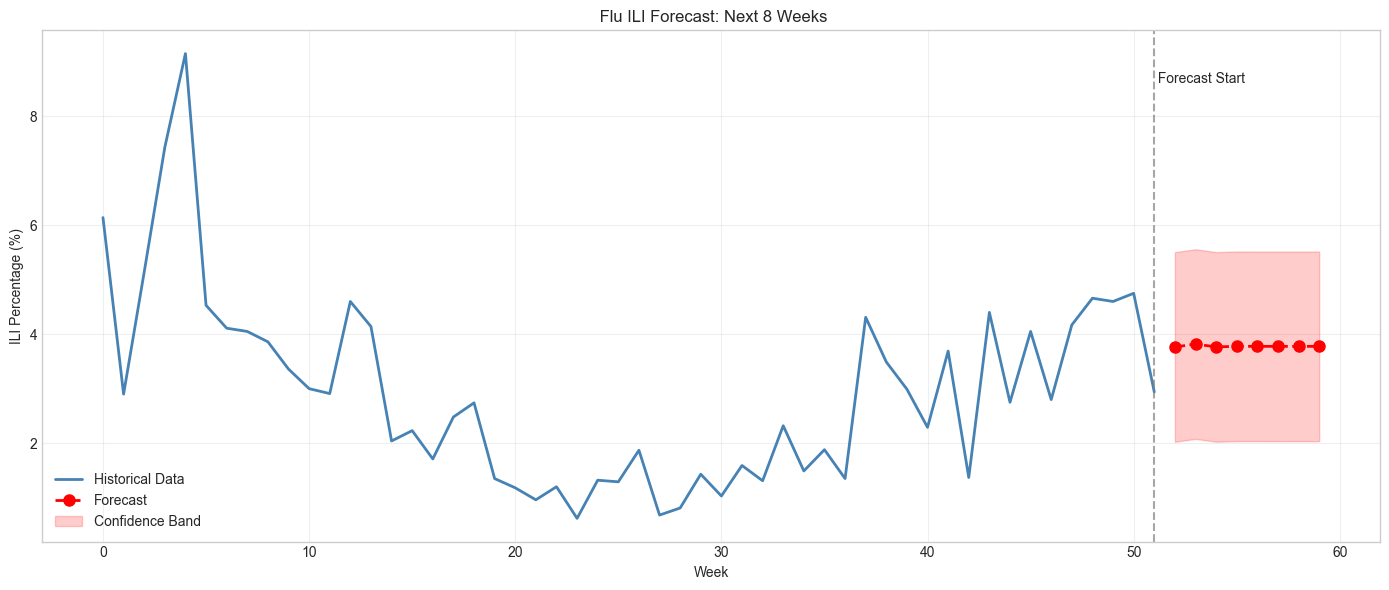

In [12]:
# Visualize forecast
plt.figure(figsize=(14, 6))

# Historical data (last 52 weeks)
history = df['ili_percentage'].values[-52:]
hist_weeks = range(len(history))
future_weeks = range(len(history), len(history) + FORECAST_WEEKS)

plt.plot(hist_weeks, history, '-', label='Historical Data', color='steelblue', linewidth=2)
plt.plot(future_weeks, future_forecast, 'o--', label='Forecast', color='red', markersize=8, linewidth=2)

# Add confidence band (simple approximation)
std = np.std(history)
plt.fill_between(future_weeks, 
                 future_forecast - std, 
                 future_forecast + std, 
                 alpha=0.2, color='red', label='Confidence Band')

plt.axvline(x=len(history)-1, color='gray', linestyle='--', alpha=0.7)
plt.text(len(history)-1, plt.ylim()[1]*0.9, ' Forecast Start', fontsize=10)

plt.xlabel('Week')
plt.ylabel('ILI Percentage (%)')
plt.title(' Flu ILI Forecast: Next 8 Weeks')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Summary

In [13]:

print(" FORECASTING SUMMARY")


print(f"\n Data:")
print(f"   • Total records: {len(df)}")
print(f"   • Training weeks: {len(train)}")
print(f"   • Test weeks: {len(test)}")

print(f"\n Best Model: ARIMA(2,1,2)")
print(f"   • MAE: {arima_metrics['MAE']}")
print(f"   • RMSE: {arima_metrics['RMSE']}")

print(f"\n Forecast (next {FORECAST_WEEKS} weeks):")
print(f"   • Average: {np.mean(future_forecast):.2f}%")
print(f"   • Range: {np.min(future_forecast):.2f}% - {np.max(future_forecast):.2f}%")



 FORECASTING SUMMARY

 Data:
   • Total records: 312
   • Training weeks: 300
   • Test weeks: 12

 Best Model: ARIMA(2,1,2)
   • MAE: 1.0296
   • RMSE: 1.1459

 Forecast (next 8 weeks):
   • Average: 3.78%
   • Range: 3.76% - 3.82%
